# Machine Translation
This notebook contains a machine translation pipeline that converts English text into French. The pipeline is divided into three parts. In the first part, text gets converted to a sequence integers. In the second part, we build a couple deep neural network models. In the last part, we use the final model to transform English text into the French translation.

In [101]:
import os
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Activation, Bidirectional, Dense, Dropout, GRU, Input, LSTM, TimeDistributed, RepeatVector
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import Adam
import matplotlib.pyplot as plt

%matplotlib inline


## Preprocessing Text
In this step, text gets converted to sequence of integers.

### Load the Text
The text data is already in lowercase and has been delimited with spaces.

In [102]:
def read_text(path):
    """
    Read text from file given by the path.
    """
    with open(path, 'r') as f:
        text = f.read()
    return text.split('\n')

english_data = read_text('data/small_vocab_en')
french_data = read_text('data/small_vocab_fr')

In [103]:
# let's preview what the text looks like in English and French
for i in range(3):
    print('En:\t {}\n'.format(english_data[i]))
    print('Fr:\t {}\n'.format(french_data[i]))
    print('-'*20)
    print('\n')

En:	 new jersey is sometimes quiet during autumn , and it is snowy in april .

Fr:	 new jersey est parfois calme pendant l' automne , et il est neigeux en avril .

--------------------


En:	 the united states is usually chilly during july , and it is usually freezing in november .

Fr:	 les Ã©tats-unis est gÃ©nÃ©ralement froid en juillet , et il gÃ¨le habituellement en novembre .

--------------------


En:	 california is usually quiet during march , and it is usually hot in june .

Fr:	 california est gÃ©nÃ©ralement calme en mars , et il est gÃ©nÃ©ralement chaud en juin .

--------------------




### Preprocess
In order to use this in a neural network, we must encode text data as integers. We'll do this with a tokenizer.

Once words are tokenized, each sentence needs to be the same length. For sentences that are short, we will add padding to the end.

In [104]:
def tokenize(strings):
    """
    Transform the sequence of words into a sequence of integers.
    :return: (sequence of integers, corpus size)
    """
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(strings)
    index_words_dict = {id: word for word, id in tokenizer.word_index.items()}
    index_words_dict[0] = '*'
    
    return tokenizer.texts_to_sequences(strings), index_words_dict

def prediction_to_text(predictions, index_words_dict):
    """
    Transform the output from a neural network into text
    """
    return ' '.join([index_words_dict[i] for i in np.argmax(predictions, 1)])

def pad(seq, maxlen=None):
    """
    Add padding to the sequence.
    """
    return pad_sequences(seq, maxlen=maxlen, padding='post')

In [105]:
english_seq, english_index_words_dict = tokenize(english_data)
french_seq, french_index_words_dict = tokenize(french_data)
english_seq = pad(english_seq)
french_seq = pad(french_seq)

# sparse_categorical_crossentropy requires labels to be in 3 dimensions
french_seq = french_seq.reshape(*french_seq.shape, 1)

In [106]:
print('There are %s distinct output tokens' % (len(french_index_words_dict) - 1))

There are 345 distinct output tokens


## Model 1: Basic RNN
Build a simple model that translate English to French. This establishes a baseline.

In [107]:
EPOCHS=30
rnn_input = pad(english_seq, french_seq.shape[1])
rnn_input = rnn_input.reshape((-1, french_seq.shape[-2], 1))
basic_rnn = Sequential()
basic_rnn.add(GRU(256, 
                  input_shape=rnn_input.shape[1:], 
                  return_sequences=True))
basic_rnn.add(TimeDistributed(Dense(1024, activation='relu')))
basic_rnn.add(Dropout(0.2))
basic_rnn.add(TimeDistributed(Dense(
                len(french_index_words_dict) - 1, # French corpus size
                activation='softmax'
                )))
basic_rnn.compile(loss=sparse_categorical_crossentropy,
                 optimizer=Adam(0.001),
                 metrics=['accuracy'])
basic_rnn.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 21, 256)           198144    
_________________________________________________________________
time_distributed_19 (TimeDis (None, 21, 1024)          263168    
_________________________________________________________________
dropout_10 (Dropout)         (None, 21, 1024)          0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 21, 345)           353625    
Total params: 814,937
Trainable params: 814,937
Non-trainable params: 0
_________________________________________________________________


In [108]:
r = basic_rnn.fit(rnn_input, french_seq, batch_size=1024, epochs=EPOCHS, validation_split=0.2
                 )

Train on 110288 samples, validate on 27573 samples
Epoch 1/30
110288/110288 [==============================] - 11s 103us/step - loss: 2.3273 - accuracy: 0.5019 - val_loss: nan - val_accuracy: 0.5800
Epoch 2/30
110288/110288 [==============================] - 11s 95us/step - loss: 1.4838 - accuracy: 0.5958 - val_loss: nan - val_accuracy: 0.6232
Epoch 3/30
110288/110288 [==============================] - 11s 97us/step - loss: 1.3011 - accuracy: 0.6237 - val_loss: nan - val_accuracy: 0.6414
Epoch 4/30
110288/110288 [==============================] - 11s 96us/step - loss: 1.1872 - accuracy: 0.6478 - val_loss: nan - val_accuracy: 0.6602
Epoch 5/30
110288/110288 [==============================] - 11s 97us/step - loss: 1.1052 - accuracy: 0.6631 - val_loss: nan - val_accuracy: 0.6797
Epoch 6/30
110288/110288 [==============================] - 11s 96us/step - loss: 1.0466 - accuracy: 0.6737 - val_loss: nan - val_accuracy: 0.6885
Epoch 7/30
110288/110288 [==============================] - 11s 99

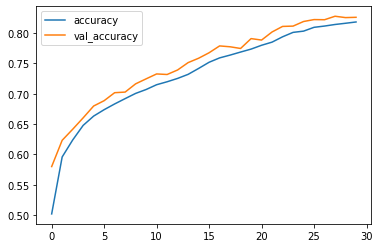

In [109]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

### Use Simple RRN Model for Translation

In [110]:
def print_translation(english, french, prediction):
    print('original english: \n\n\t{}'.format(english))
    print('\n')
    print('original translation: \n\n\t{}'.format(french))
    print('\n')
    print("model's translation: \n\n\t{}".format([prediction]))
    print('\n')
    
translation = prediction_to_text(basic_rnn.predict(rnn_input[:1])[0], french_index_words_dict)
translation = ''.join([i for i in translation if i != '*']) # drops padding

print_translation(english_data[:1], french_data[:1], translation)

original english: 

	['new jersey is sometimes quiet during autumn , and it is snowy in april .']


original translation: 

	["new jersey est parfois calme pendant l' automne , et il est neigeux en avril ."]


model's translation: 

	['new jersey est parfois calme en mois de il et il est avril en avril      ']




## Model 2: Bidirectional Encoder/Decoder
Make a bidirectional RNNs to create a new word sequence that contains both the original sequence and the original sequence in reverse. Since the new sequence is a combination of words in both directions, name entities can be correctly marked.

Use an embedding layer to capture the word relationships.

Create an RNN encoder so that a condense representation of the information is learned from the input word sequence.

Create a decoder that produces a new sequence in the target language from the output vectors of the encoder.


In [111]:
input_shape = english_seq.shape

EMBEDDING_DIM = 100
english_corpus_size = len(english_index_words_dict)
french_corpus_size = len(french_index_words_dict)
output_sequence_length = french_seq.shape[1]

model = Sequential()
model.add(
    Embedding(
        english_corpus_size,
        EMBEDDING_DIM,
        input_length = input_shape[1],
        input_shape = input_shape[1:]
    )
)
#Encoder
# model.add(Bidirectional(GRU(128)))
model.add(Bidirectional(LSTM(128)))
model.add(RepeatVector(output_sequence_length))
#Decoder
# model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(TimeDistributed(Dense(256, activation='relu')))
model.add(Dropout(0.2))
#Prediction
model.add(TimeDistributed(Dense(french_corpus_size, activation='softmax')))
model.compile(loss=sparse_categorical_crossentropy,
             optimizer=Adam(0.001),
             metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 15, 100)           20000     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 256)               234496    
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 21, 256)           0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 21, 256)           394240    
_________________________________________________________________
time_distributed_21 (TimeDis (None, 21, 256)           65792     
_________________________________________________________________
dropout_11 (Dropout)         (None, 21, 256)           0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 21, 346)         

In [112]:
r = model.fit(english_seq, french_seq, batch_size=1024, epochs=EPOCHS, validation_split=0.2)

Train on 110288 samples, validate on 27573 samples
Epoch 1/30
110288/110288 [==============================] - 14s 131us/step - loss: 2.9081 - accuracy: 0.4589 - val_loss: 2.2268 - val_accuracy: 0.5072
Epoch 2/30
110288/110288 [==============================] - 13s 119us/step - loss: 1.9450 - accuracy: 0.5250 - val_loss: 1.6637 - val_accuracy: 0.5653
Epoch 3/30
110288/110288 [==============================] - 13s 120us/step - loss: 1.5760 - accuracy: 0.5774 - val_loss: 1.3792 - val_accuracy: 0.6199
Epoch 4/30
110288/110288 [==============================] - 13s 120us/step - loss: 1.3655 - accuracy: 0.6202 - val_loss: 1.2397 - val_accuracy: 0.6500
Epoch 5/30
110288/110288 [==============================] - 13s 120us/step - loss: 1.2044 - accuracy: 0.6556 - val_loss: 1.0703 - val_accuracy: 0.6887
Epoch 6/30
110288/110288 [==============================] - 13s 122us/step - loss: 1.0729 - accuracy: 0.6875 - val_loss: 0.9596 - val_accuracy: 0.7166
Epoch 7/30
110288/110288 [=================

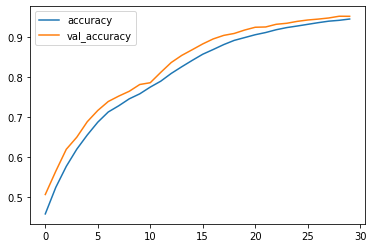

In [113]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

### Use Final Model for Translation

In [114]:
to_predict = english_seq[:1]
prediction = model.predict(to_predict, len(to_predict))
translation = [french_index_words_dict[np.argmax(i)] for i in prediction[0]]
translation = ' '.join([i for i in translation if i != '*'])
print_translation(english_data[:1], french_data[:1], translation)

original english: 

	['new jersey is sometimes quiet during autumn , and it is snowy in april .']


original translation: 

	["new jersey est parfois calme pendant l' automne , et il est neigeux en avril ."]


model's translation: 

	["new jersey est parfois calme pendant l' automne et il est neigeux en avril"]


